In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
def make_df_summary(df, strategy="best", operations=None):
    # default operations
    if operations is None:
        operations = ["enhance", "suppress"]

    # Ensure strategy is either 'best' or is one of the operations
    if strategy != "best" and strategy not in operations:
        raise ValueError(
            f"strategy must be 'best' or one of {operations}, but got '{strategy}'"
        )
        
    # Define the metrics we want to handle
    # "gap_correct" => mean_diff_conf_correct
    # "gap_incorrect" => mean_diff_conf_incorrect
    # "loss_correct" => mean_loss_correct
    # "loss_incorrect" => mean_loss_incorrect
    metric_pairs = [
        ("gap", "correct", "mean_diff_conf_correct"),
        ("gap", "incorrect", "mean_diff_conf_incorrect"),
        ("loss", "correct", "mean_loss_correct"),
        ("loss", "incorrect", "mean_loss_incorrect"),
    ]
    
    # Compute "best" (or operation-specific) columns and diffs vs. baseline
    for mtype, corinc, prefix in metric_pairs:
        # The column name(s) for the modifications look like:
        # mean_diff_conf_correct_mod_ENHANCE, or mean_loss_correct_mod_SUPPRESS, etc.
        mod_cols = [f"{prefix}_mod_{op}" for op in operations]
        baseline_col = f"{prefix}_baseline"
        best_col = f"best_{mtype}_{corinc}"
        diff_col = f"diff_{mtype}_{corinc}"

        if strategy == "best":
            # pick the minimum among all possible operations
            df[best_col] = df[mod_cols].min(axis=1)
        else:
            # pick the one relevant operation
            df[best_col] = df[f"{prefix}_mod_{strategy}"]

        # difference from baseline
        df[diff_col] = df[best_col] - df[baseline_col]

    # Build final subset of columns to return
    # (you can add or remove columns depending on your needs)
    keep_cols = [
        # grouping/condition columns
        "tgt_rank", "misclf_combined", "method", "n_ratio", "w_num", "beta",
        # newly created columns
        "best_gap_correct", "diff_gap_correct",
        "best_loss_correct", "diff_loss_correct",
        "best_gap_incorrect", "diff_gap_incorrect",
        "best_loss_incorrect", "diff_loss_incorrect",
    ]

    # Ensure tgt_rank is integer
    if "tgt_rank" in df.columns:
        df["tgt_rank"] = df["tgt_rank"].astype(int)

    df_summary = df[keep_cols].copy()

    return df_summary

In [6]:
# CSV ファイルを読み込み（例："all_experiment_results.csv"）
df1 = pd.read_csv("exp-fl-4-4.csv")
df1 = df1[df1["method"] != "ours"]
df2 = pd.read_csv("exp-fl-6-2.csv")
# df1と df2 をたてに結合
df = pd.concat([df1, df2], axis=0)
print(df.shape)

(140, 39)


In [8]:
# misclf_type と fpfn を統合する関数
def combine_misclf(row):
    if pd.isna(row["fpfn"]) or row["fpfn"] in [None, ""]:
        return row["misclf_type"]
    else:
        return f"{row['misclf_type']}_{row['fpfn']}"

# 新しい列 misclf_combined を作成
df["misclf_combined"] = df.apply(combine_misclf, axis=1)

op_list = ["enhance", "suppress", "multiply-2"]
df_best = make_df_summary(df, strategy="best", operations=op_list)
df_enh = make_df_summary(df, strategy="enhance", operations=op_list)
df_sup = make_df_summary(df, strategy="suppress", operations=op_list)
print(df_best.shape)
print(df_enh.shape)
print(df_sup.shape)

(140, 14)
(140, 14)
(140, 14)


In [9]:
def show_heatmaps(df_summary, beta):
    ordered_ranks = [1, 2, 3, 4, 5]
    ordered_misclf = ["src_tgt", "tgt", "tgt_fp", "tgt_fn"]
    methods = ["ours", "bl", "random"]
    # metric_names = ["diff_gap_correct", "diff_loss_correct", "diff_gap_incorrect", "diff_loss_incorrect"]
    # row_titles = ["Gap (Correct)", "Loss (Correct)", "Gap (Incorrect)", "Loss (Incorrect)"]
    metric_names = ["diff_loss_correct", "diff_loss_incorrect"]
    row_titles = ["Loss (Correct)", "Loss (Incorrect)"]

    fig, axes = plt.subplots(nrows=len(metric_names), ncols=3, figsize=(18, 8))
    cmap = "RdBu_r"

    # 各行（=同じmetric）ごとにvmin, vmaxをそろえる
    for row_index, metric in enumerate(metric_names):
        # すべてのmethodsに対する最大・最小値を抽出
        row_vals = []
        for method in methods:
            if method != "ours":
                df_method = df_summary[df_summary["method"] == method]
            else:
                # "ours"の場合は、betaでも選択
                df_method = df_summary[(df_summary["method"] == "ours") & (df_summary["beta"] == beta)]
            values = df_method[metric].values
            row_vals.extend(values[~np.isnan(values)])  # 欠損値除外
        vmin = min(row_vals)
        vmax = max(row_vals)

        # ここで中心を0に近づける場合（任意）
        max_abs = max(abs(vmin), abs(vmax))
        vmin, vmax = -max_abs, max_abs

        for col_index, method in enumerate(methods):
            ax = axes[row_index, col_index]
            if method != "ours":
                df_method = df_summary[df_summary["method"] == method]
            else:
                # "ours"の場合は、betaでも選択
                df_method = df_summary[(df_summary["method"] == "ours") & (df_summary["beta"] == beta)]
            pivot_table = df_method.pivot_table(index="tgt_rank", columns="misclf_combined", values=metric)
            pivot_table = pivot_table.reindex(index=ordered_ranks, columns=ordered_misclf)

            sns.heatmap(pivot_table, ax=ax, annot=True, fmt=".7f", cmap=cmap,
                        center=0, vmin=vmin, vmax=vmax, cbar_kws={"shrink": 0.6})

            if method != "ours":
                ax.set_title(f"{method} - {row_titles[row_index]}")
            else:
                ax.set_title(f"ours (beta={beta}) - {row_titles[row_index]}")
            ax.set_xlabel("")
            ax.set_ylabel("tgt_rank")

    plt.tight_layout()
    plt.show()
    return fig

# 上はbeta=0.5の場合なのでbetaごとに比較できるようにする

beta = 0.1

Best


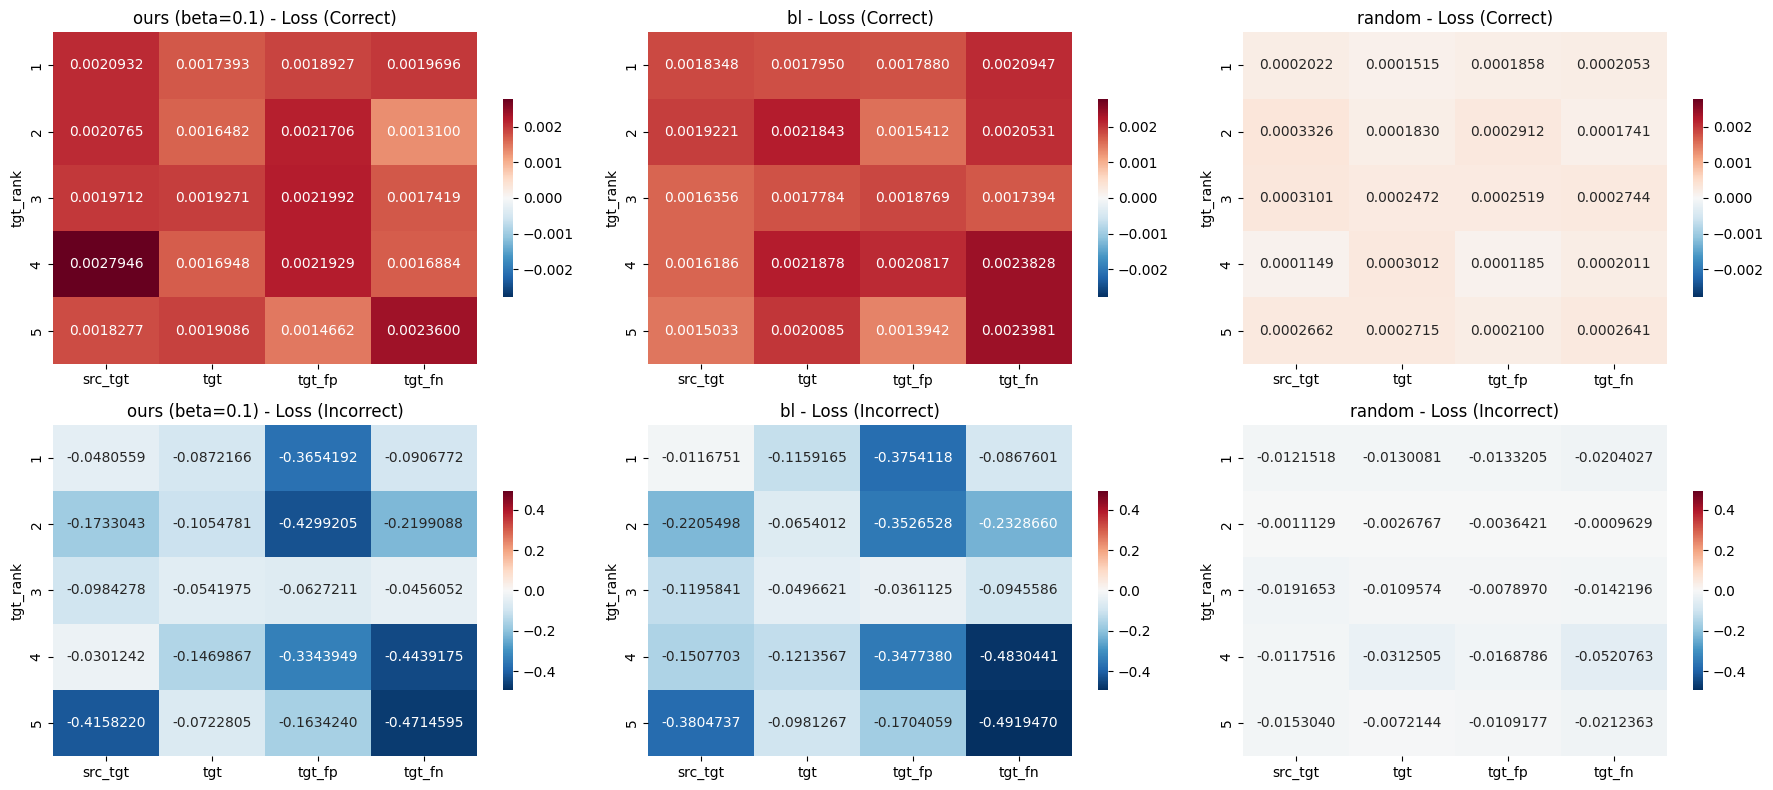

beta = 0.25

Best


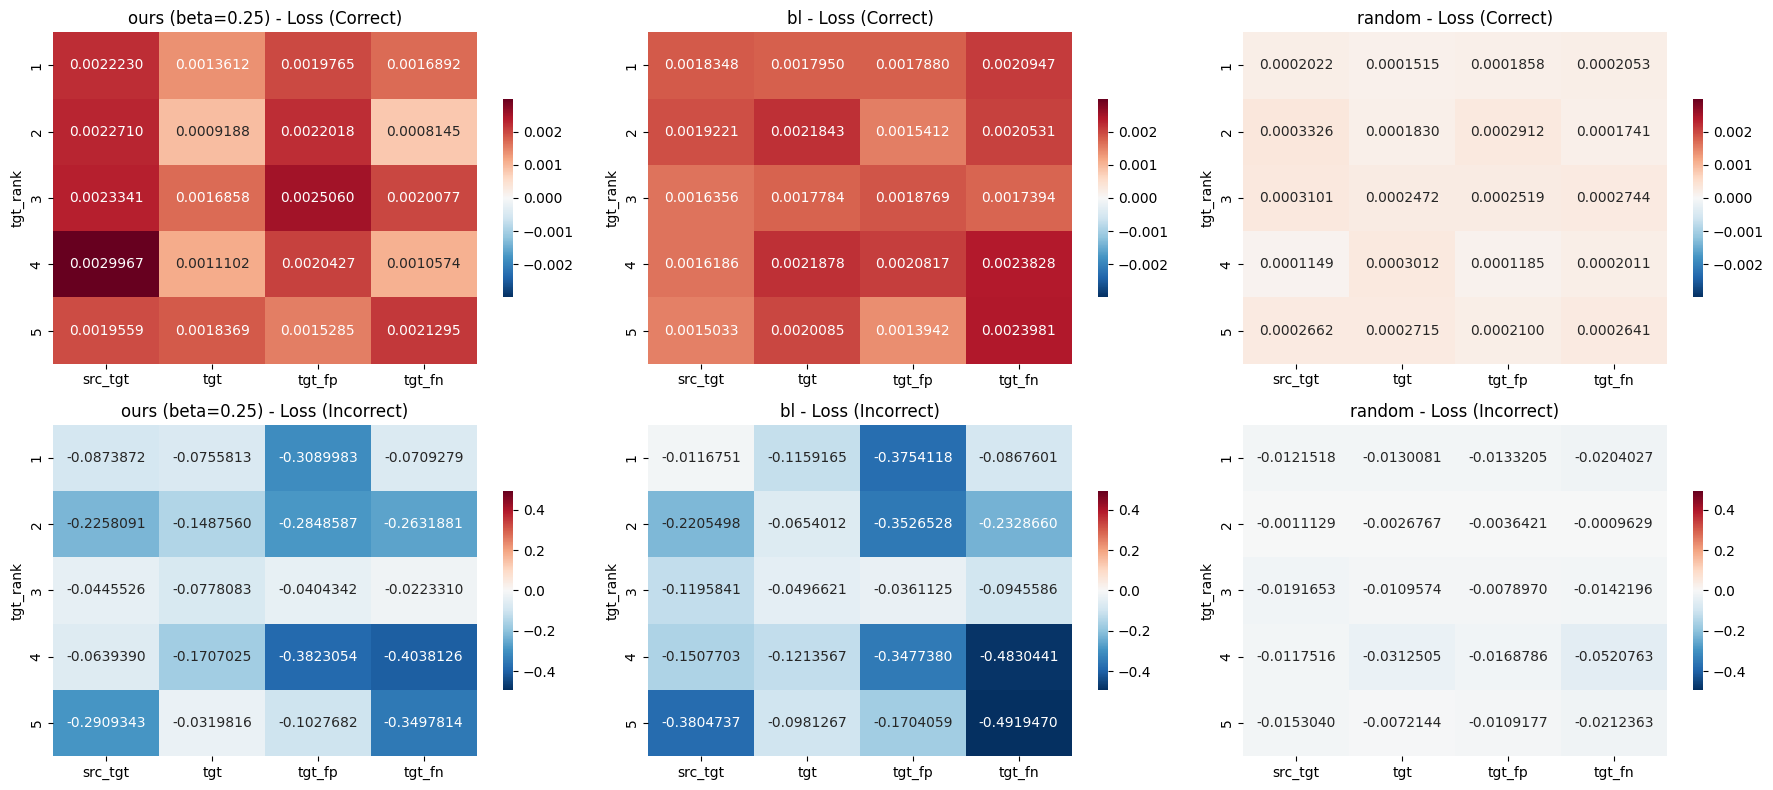

beta = 0.5

Best


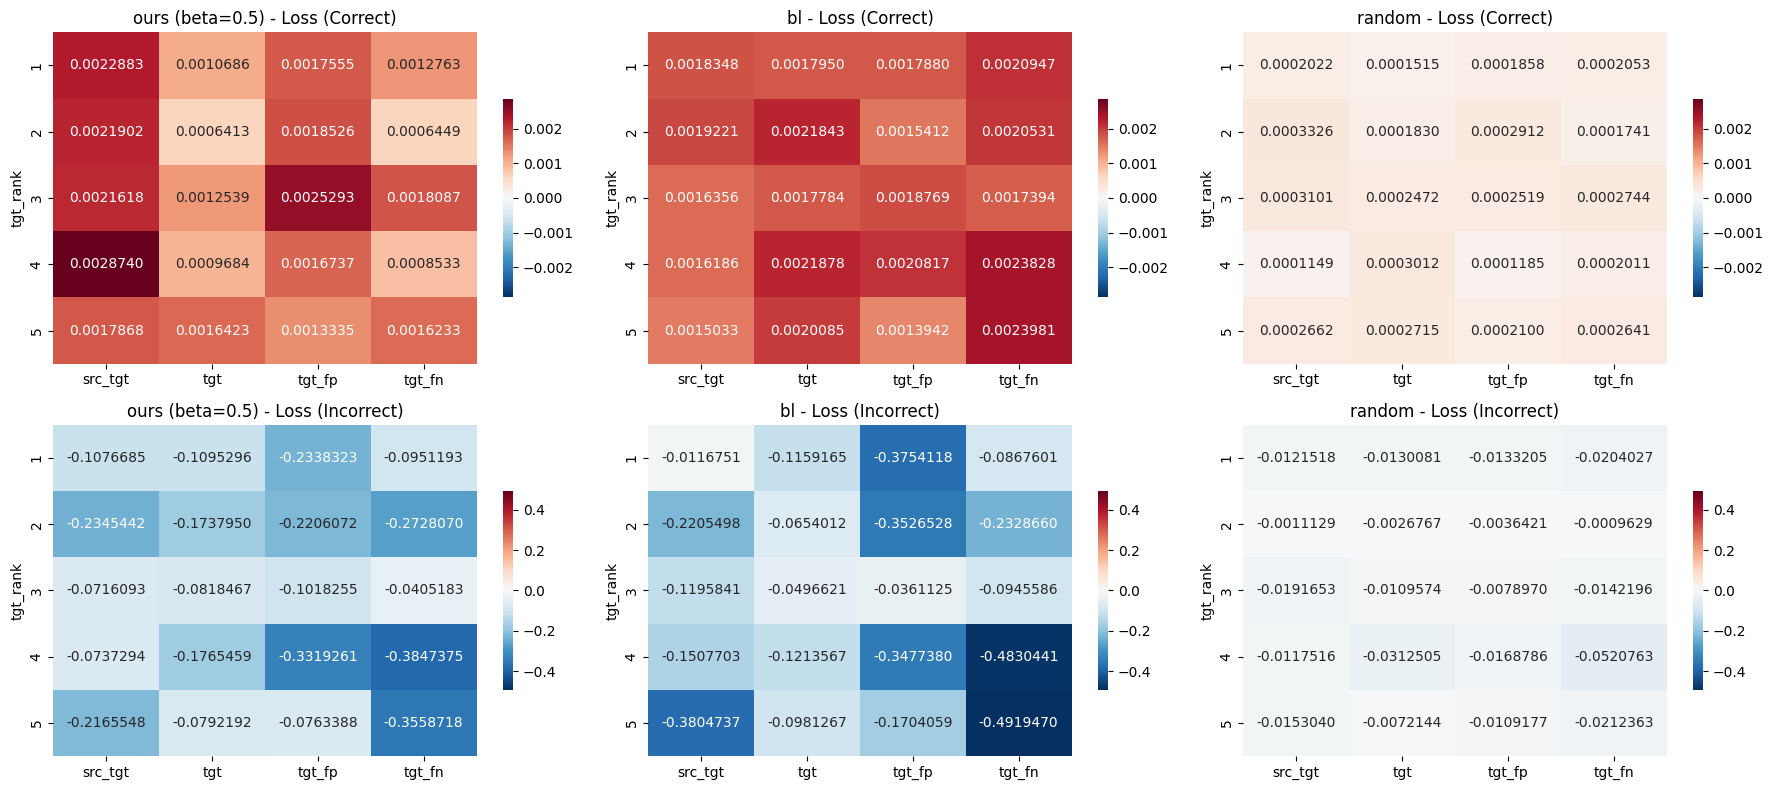

beta = 0.75

Best


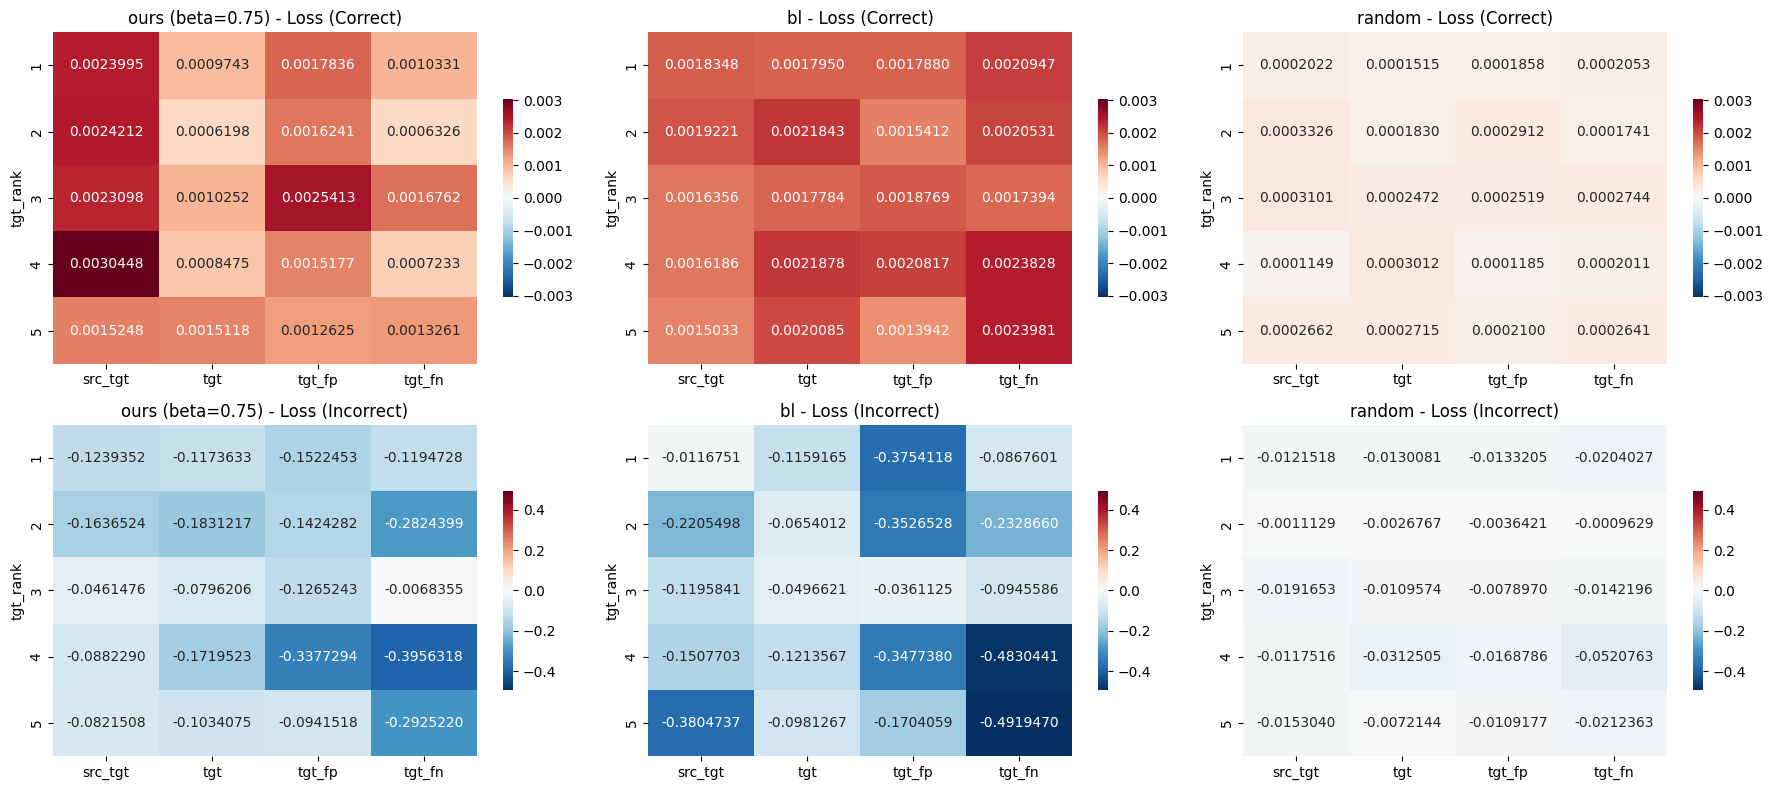

beta = 1.0

Best


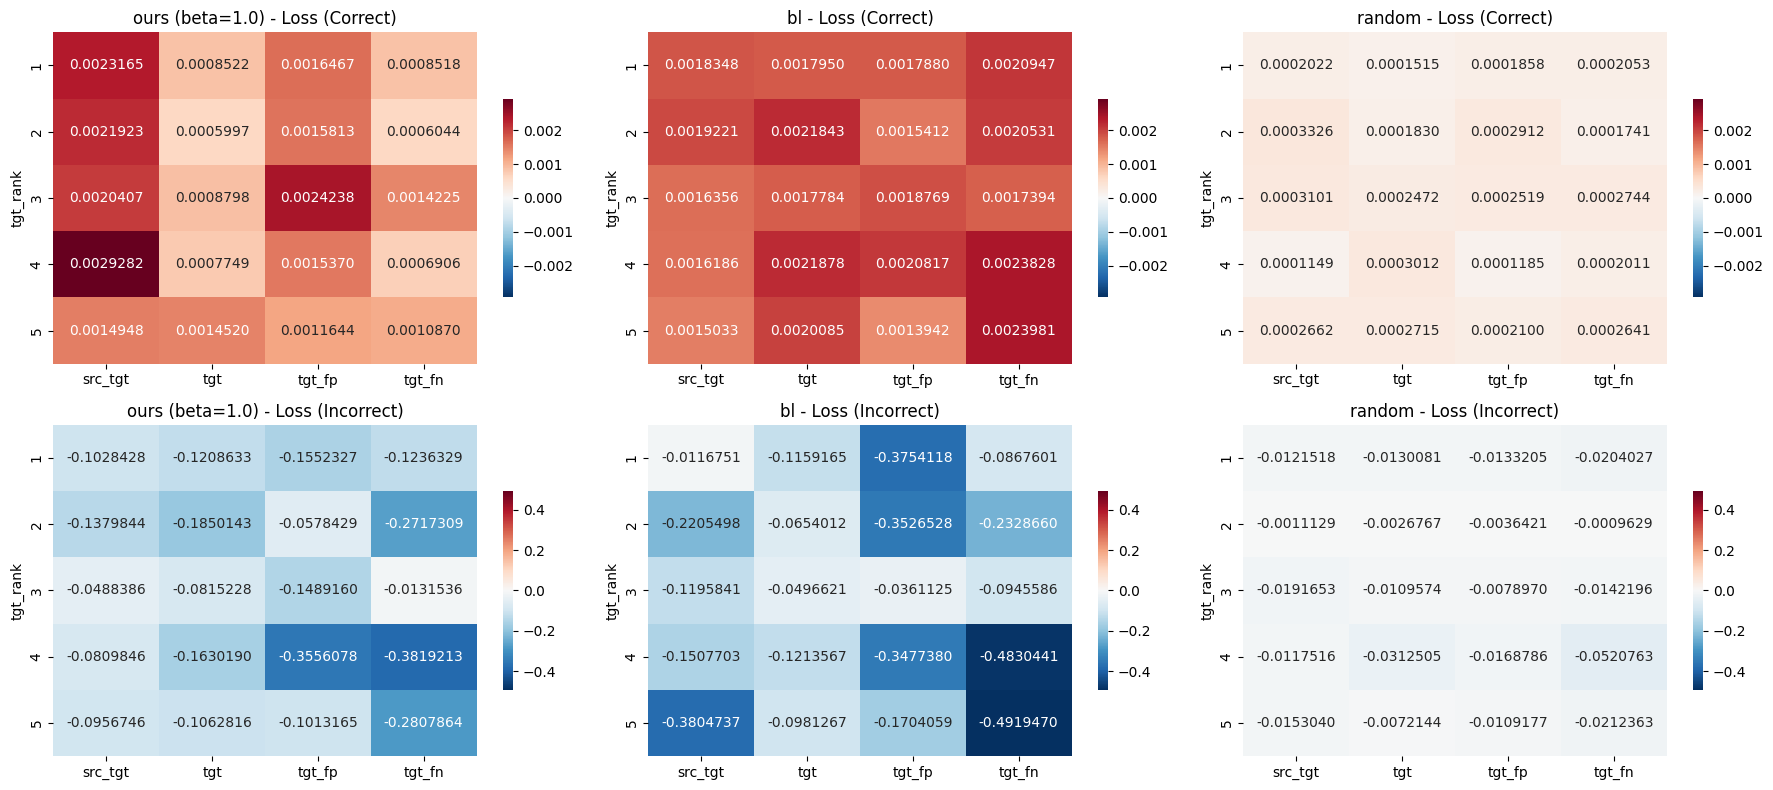

In [10]:
beta_list = [0.1, 0.25, 0.5, 0.75, 1.0]

for beta in beta_list:
    print(f"=======================\nbeta = {beta}\n=======================\n")
    print("Best")
    fig_best = show_heatmaps(df_best, beta)
    # print("Enhance")
    # fig_enh = show_heatmaps(df_enh, beta)
    # print("Suppress")
    # fig_sup = show_heatmaps(df_sup, beta)